# Image Search Engine

## Introduction

Have you ever used or seen an Image Search Engine like [Tin Eye](https://www.tineye.com/)? An image search engine works in that you give it an image to query, and it will give you back some images from the database that it deem to be similiar to the image you used to query. This is exactly what we are going to learn to build today!

### The Big Picture:
First, we would need to create a dataset of images that we can search through. I have created a folder called images that contains 17 images so far. You can get this folder [here](https://drive.google.com/open?id=1fV3NpoAcbUSeXFkjOJ2KCLq8TbrnFjPP) and unzip it to use. Of course, the bigger your dataset of images are, the better and the more likely you would be able to get similiar images to your query image. 

Now, we would need to go through our dataset and "describe" each image and store these "descriptions" for later use like when we need to query images. 

We "describe" an image by extracting features and quantifying it into a feature vector. The "description" would essentially be a a list of numbers used to represent an image.

To see how similiar two images are, we take each image's feature vector and use a distance or histogram comparison method to compute the difference between the two feature vectors. Our image search engine would employ this method to determine how similiar each image in the databset is to the query image and be able to give back the top search results. 

In a sense, instead of what we are used to by searching up images in Google using keywords, searches are only done based on the informaiton given by a image that is used to perform the query. This method of searching is known as [Content Based Image Retrieval (CBIR) systems](https://en.wikipedia.org/wiki/Content-based_image_retrieval)

So for my example databset of images, if I were to use a image of cat on grass as my search image, I would expect to get back other images in my database that are also cats on grass instead of images of turtles. 

### Tutorial content

These are the general steps needed to make this search engine:
1. [Installation and Imports](#Installation-and-Imports)
2. [Define Custom Variables](#Define-Custom-Variables)
3. [Create Our Image Descriptor](#Create-Our-Image-Descriptor)
4. [Apply Image Descriptor to All Dataset Images](#Apply-Image-Descriptor-to-All-Dataset-Images)
5. [Examine the Differrent Comparison Methods](#Examine-the-Differrent-Comparison-Methods)
6. [Generate the Correlation Score for Every Dataset Image](#Generate-the-Correlation-Score-for-Every-Dataset-Image)
7. [Display The Images](#Display-The-Images)
8. [Running the Whole Thing](#Running-the-Whole-Thing)
9. [Additional Resources](#Additional-Resources)

### Now let's get started!

### Installation and Imports
This tutorial is done in Python 3.6 with OpenCV 3.4
Assuming everyone in this class alreayd has Python 3.5+ and pip successfully installed we now need to make sure we install the most up to date version of OpenCV. 

Run the following code to install OpenCV in your command line

Run the following code bloc to import it and to check that your OpenCV is at version 3.4.0.

(This is important because some builtin functions are different in version 2 and 3)

In [1]:
import cv2
print(cv2.__version__)

3.4.0


Now we will import the rest of the necessary packages. 

- NumPy would be used for numerical processing
- os used to traverse through local directory to get the images
- csv used to utilize csv files to store our extracted features/descriptions from our image dataset
- SciPy.spatial's distance package gives us various implementations of distance functions we could use to calculate similarities 
- matplotlib is used to display our image results

In [2]:
import numpy as np
import os
import csv
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt

### Define Custom Variables
Before we run the actual thing, we should set some custom variables. We should set the path of the query image the directory of the image dataset where the search would be run and what the dataset feature storage file would be called.

In [3]:
# replace [3] with the number of top relevant images you want to display
showNum = 3 

#replace ['images'] with the image dataset directory that you created
images_path = 'images'+ '/' 

#replace ['catgrass_yawn.jpg'] with the image you want to search
query_path = images_path + 'fox_mugshot.jpg' 

# replace ['features_dataset'] with what you want to name your feature storage file
allfeatures_filename = 'features_dataset' + '.csv'

### Create Our Image Descriptor
(This function generates the actual histogram and will be called in the actual describe function later)
In this function we are taking in an image and using cv2 to generate a matrix containing the histogram value of the image using cv2.calcHist

To explain a little about the parameters 

calcHist([image], channels, mask, binSize, colorRanges)

  1. image: source image and passed in with [] around
  2. channels: indicates which color channels we will be working with
        - If greyscale, it'll just be [0], but [0,1,2] means we want all the RGB channels
  3. mask: the region of the image where you want to generate histogram from. If you want the full image, pass in None
  4. binSize: Since we are working with all three RGB channels here, we will pass in a binSize for each channel, hence the three 8s
        - (What are bins? Think of bins as distinct groups each with a distinct pixel intensity label. Histograms are generated by categorizing the pixels of an image and see how many pixels fall into each bin/category. The bigger the dataset of images we would want larger bin sizes and smaller bin sizes for smaller dataset. For smaller dataset, we would want the histogram categorization be more general so that our query image could actually have similiar histogram values with the dataset images. A common binSize to use for relatively smaller datasets is 8, which is what I chose )
  5. colorRanges: the range that we are working with. We want the full range for each channel here in this case so we set 0, 256 for all of them as 0 is the lowest bound(inclusive) and 256 is the highest bound(exclusive). 
  
We need to normalize the histogram like in Line 6 so we can make the image scale invariant. This means that no matter how much we manipulate the size and scale or rotate the image, the histogram value of the image would still remain the same. 

Finally we need to flatten the histogram matrix to 1 dimension so that it turns into a list of numerical value of pixel intensity for our ease of use.

In [4]:
# Feature extractor
def generate_histogram(img, mask):
    try:       
        hist = cv2.calcHist([img], [0, 1, 2], mask, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        Normalized_hist = cv2.normalize(hist, hist)
        hist = Normalized_hist.flatten()
        
    # give feedback of the error if error occurs
    except cv2.error as e:
        print ('Error: ', e)
        return None

    return hist


This describe function will do all the prepping and call generate_histogram to eventually return a list of features for a particular image.

To have more accuracy, instead of just keeping a histogram value of the entire image, it is better to split the image into different regions.
we are going to divide our image into 5 different regions: 
  1. the top-left corner 
  2. the top-right corner
  3. the bottom-right corner
  4. the bottom-left corner 
  5. the center of the image. (which we will now define as an ellipse shape)
  
 
Lines 12 - 15 defines the indexes of our top-left, top-right, bottom-right, and bottom-left regions, respectively.

Then, we would want to make an ellipse for the center of the image. On Line 18, we defined an ellipse with radius that is 75% of the width and height of the image

On Line 20, we initialize a blank image with black background (represented by all zeros) with the same dimensions of the particular image

Finally, on Line 21, we use the cv2.ellipse function to draw the ellipse. the 8 parameters it takes in are:
1. blank: The blank image we want to draw the ellipse on.
2. (centerX, centerY): A tuple representing the center (x, y) coordinates of the image.
3. (axesX, axesY): A tuple representing the length of the axes of the ellipse. Our ellipse has 75% of the width and height of the current image.
4. 0: Means the ellipse has no rotation
5. 0: The starting angle of the ellipse.
6. 360: The ending angle of the ellipse. From the starting angle of 0 to the ending angle of 360 means that we are drawing a full ellipse
7. 255: means that the color of the ellipse will be white 
8. -1: The border size of the ellipse. This negative value means the ellipse is opaque

For Line 28 - 35: we now construct a mask for each corner of the image and subtract the region where the center ellipse would overlap. We then add each corner onto our list of features of the particular image

In [5]:
def describe(image_path):
    # load in the image with cv2
    image = cv2.imread(image_path)
    features = []

    # find the dimensions and compute the center of the image
    (height, width) = image.shape[:2]
    (centerX, centerY) = (int(width * 0.5), int(height * 0.5))

    # divide the image into four rectangles/regions:  
    # (top-left, top-right, bottom-right, bottom-left)
    regions = [(0, centerX, 0, centerY), 
                (centerX, width, 0, centerY), 
                (centerX, width, centerY, height), 
                (0, centerX, centerY, height)]

    # construct an elliptical mask representing the center of the image
    (ellipX, ellipY) = (int(width * 0.75/2), int(height * 0.75/2))
    # images are either of type(dtype) uint8 or float32
    ellipBlank = np.zeros(image.shape[:2], dtype = "uint8")
    cv2.ellipse(ellipBlank, (centerX, centerY), (ellipX, ellipY), 0, 0, 360, 255, -1)
    
    # compute the histogram for elliptical region and update the feature list
    hist = generate_histogram(image, ellipBlank)
    features.extend(hist)
    
    # loop over the regions
    for (startX, endX, startY, endY) in regions:
        cornerBlank = np.zeros(image.shape[:2], dtype = "uint8")
        cv2.rectangle(cornerBlank, (startX, startY), (endX, endY), 255, -1)
        cornerMask = cv2.subtract(cornerBlank, ellipBlank)

        # compute the histogram for the current region and update the feature list
        hist = generate_histogram(image, cornerMask)
        features.extend(hist)

    return features

### Apply Image Descriptor to All Dataset Images
Now with our image descriptor function "describe" written, we will apply that to every image in our dataset and store them in a file. 

Line 5 we open up a file to store our extracted features from each image. We could do this just by using a Python dictionary but for large datasets it makes more sense to run and process everything once and have a concrete dataset of information of features ready to go everytime you want to call it.

For each of the images we will set the imageID just as the filename of the image. For this tutorial, we are assuming all the filename of the images are unique.

After we load the image on Line 14, we will pass the image into our descrcibe function, which will give us back a list of floating point values that contains the "descriptions"/feature of the particular image. We then store that back into our csv file.

In [6]:
def batch_extractor(images_path):
    # get all the image paths in the dataset directory given
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    
    dataset = open(allfeatures_filename, "w")
     
    for imagePath in files:
        # ".DS_Store" is a default file in Mac OS folders that we should ignore
        if ".DS_Store" in imagePath: continue
        # extract the image ID (the unique filename) from the image
        imageID = imagePath[imagePath.rfind("/") + 1:  ]

        # get features from the image
        descriptions = describe(imagePath)

        # write the features to file
        features = [str(des) for des in descriptions]
        dataset.write("%s,%s\n" % (imageID, ",".join(features)))

    # close the dataset file
    dataset.close()
        

### Examine the Differrent Comparison Methods

#### -- From OpenCV:
OpenCV has a builtin method for histogram comparison :
    
    cv2.compareHist(Histogram_1, Histogram_2, comparison_method)

This method takes in 3 arguments: Histogram_1 and Histogram_2 are the two image histograms that are getting compared while the comparison_method is what method openCV uses to compare these two histograms

The comparison methods can be any of the following:

- cv2.HISTCMP_CORREL: Computes the correlation between the two histograms.
- cv2.HISTCMP_CHISQR: Applies the Chi-Squared distance to the histograms.
- cv2.HISTCMP_INTERSECT: Calculates the intersection between two histograms.
- cv2.HISTCMP_BHATTACHARYYA: Bhattacharyya distance, used to measure the “overlap” between the two histograms.

I have bundled these methods together in a OPENCV_METHODS list that I could loop over

In [7]:
# initialize OpenCV methods for histogram comparison
OPENCV_METHODS = [("cv","Correlation", cv2.HISTCMP_CORREL),
                  ("cv","Chi-Squared", cv2.HISTCMP_CHISQR),
                  ("cv","Intersection", cv2.HISTCMP_INTERSECT ), 
                  ("cv","Hellinger", cv2.HISTCMP_BHATTACHARYYA)]


#### -- From SciPy distance:

The main difference between using SciPy distance functions and OpenCV methods is that the methods in OpenCV are histogram specific. This is not the case for SciPy, which implements much more general distance functions. However, they are still important to note and you can likely make use of them in your own applications.
Another set of ways to evaluate the simmiliarities is through SciPy's distance functions 

OpenCV's compareHist() method is very histogram dependent while the SciPy distance funcitons are more general

The SciPy distance funtions can be any of the following:

- dist.euclidean
- dist.cityblock 
- dist.chebyshev 

In [8]:
# initialize the scipy methods to compaute distances
SCIPY_METHODS = [("scipy", "Euclidean", dist.euclidean),
                 ("scipy", "Manhattan", dist.cityblock),
                 ("scipy", "Chebysev", dist.chebyshev)]

### Generate the Correlation Score for Every Dataset Image
Now we would need to make a class that performs the actual matching of  the dataset images to our query image.

We would keep a dictionary called correlations that will keep track of how similiar each image in our dataset image is to our query image by using the OpenCV's compareHist methods or SciPy distance functions described earlier.

In [9]:
class Matcher(object):
    def __init__(self, all_featuresPath):
        self.all_featuresPath = all_featuresPath
        
    def match(self, queryFeatures, method):
        # initialize our dictionary of result correlations
        correlations = {}
        # open the feature storage file for reading
        with open(self.all_featuresPath) as f:
            # initialize the CSV reader
            reader = csv.reader(f)
 
            # loop over the rows in the feature storage file
            for row in reader:
                # these 2 lines are needed for compareHist to work properly as it
                # takes in proper np.array type of float32
                # row [1:] so that we parse out the filename and just work with 
                # the floats representing the features
                row_features = np.array([np.float32(x) for x in row[1:]])
                queryFeatures = np.array([np.float32(x) for x in queryFeatures])
                
                # Now compute the similiarities between the features in our storage
                # and our query features using the comparison method passed in
                # d represents the difference/distance between the 2 images' histograms
                
                # I differentiated OpenCV methods and SciPy distance functions by
                # labeling them with the first element of the methods tuple
                if method[0] == 'cv':
                    d = cv2.compareHist(queryFeatures,row_features,method[2])
                else:
                    d = method[2](queryFeatures,row_features)
 
                # we now add the computed value into our correlations dictionary
                # key is the current image ID's (row[0])
                # value is the difference/distance we just computed
                # representing how 'similar' the image in the dataset is to our query image
                correlations[row[0]] = d
                
            # close the feature storage file
            f.close()
 
        # sort our results 
        # so that the smaller difference/distances(the more relevant) images are at the front
        correlations = sorted([(v, k) for (k, v) in correlations.items()])
        return correlations


### Display The Images
This show method is able to first let OpenCV read the image with the image path passed in

By default, OpenCV stores images in BGR format rather than RGB. However, because we arre using matplotlib to display our result images and matplotlib would expect the image given to be in RGB format, we would need to convert it. cv2.cvtColor on Line 3 easily converts the image from BGR to RGB so it is displayed as we are used to.

In [10]:
def show_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

### Running the Whole Thing
For the main run function, Line 2 - 5 we generate the features for our query image and create the dataset that contains the features of our source images. We also generate a Matcher instance with the dataset we just generate passed in.

We would first want to display the query image

Then, we will run through matches with the 2 different domains of similiarity calculation methods: OpenCV methods and SciPy distance functions.

For each of the 2 sets, I display the different results from each individual methods within the domain and displaying the top however number of results you determine with showNum. 

Query image ==========================================


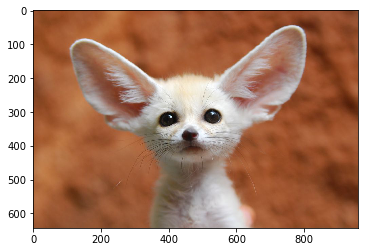

Now showing using SciPy distance functions ==================================================
Result images from SciPy distance function: "Euclidean" ========================================
Match level: 1.120786805586249e-06


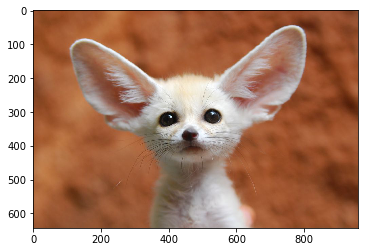

Match level: 2.9621288776397705


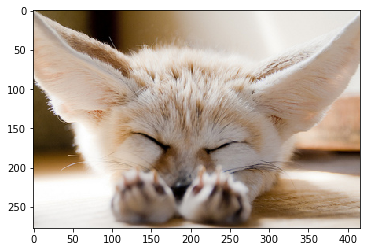

Match level: 2.9850826263427734


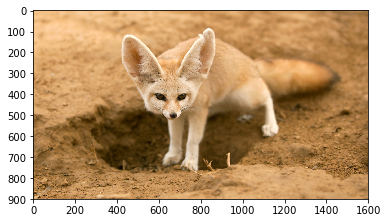

Result images from SciPy distance function: "Manhattan" ========================================
Match level: 6.00056e-06


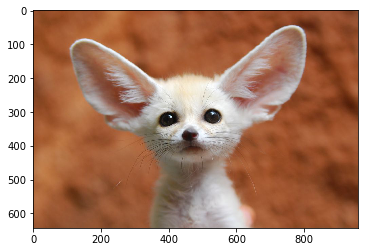

Match level: 19.596


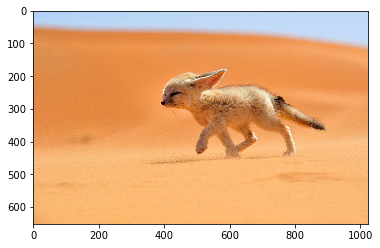

Match level: 22.5327


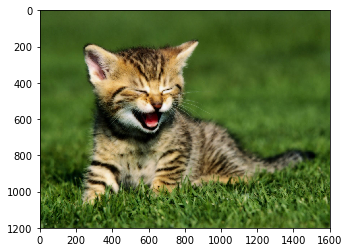

Result images from SciPy distance function: "Chebysev" ========================================
Match level: 4.76837e-07


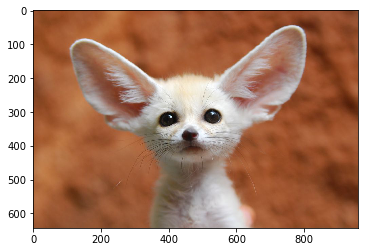

Match level: 0.901427


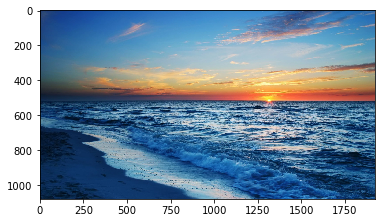

Match level: 0.922295


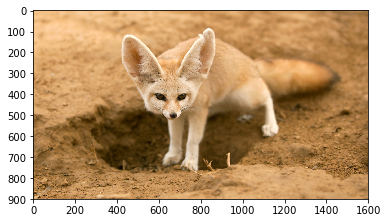

Now showing using OpenCV methods =======================================================
These methods have shown to be less accurate than the SciPy distance functions for my particular database
Result images from OpenCV method: "Correlation" ========================================
Match level: -0.012141399866394712


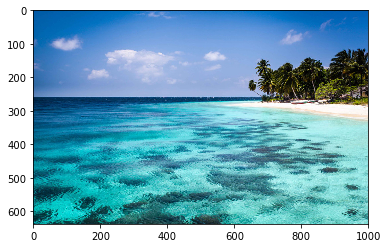

Match level: -0.004881887266310865


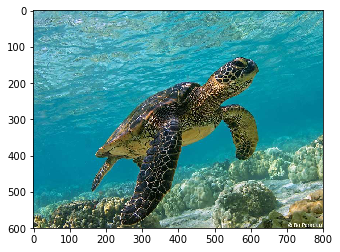

Match level: -0.0002523494029161912


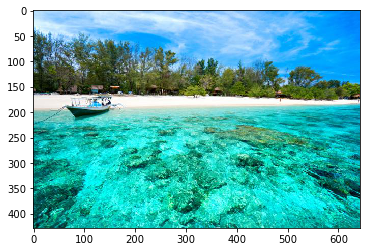

Result images from OpenCV method: "Chi-Squared" ========================================
Match level: 6.5523185413109896e-12


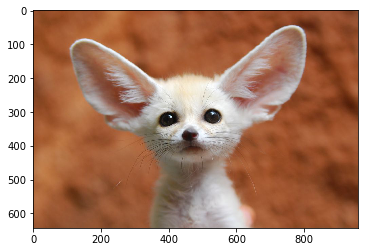

Match level: 246.19593225776458


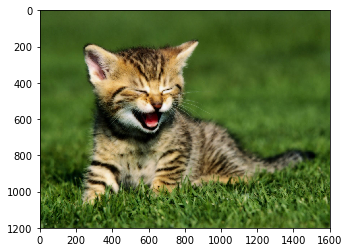

Match level: 316.47125238866056


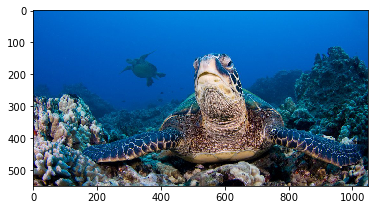

Result images from OpenCV method: "Intersection" ========================================
Match level: 0.3111479300928295


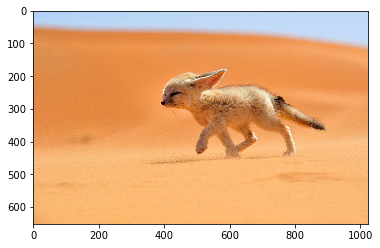

Match level: 0.38704754271748243


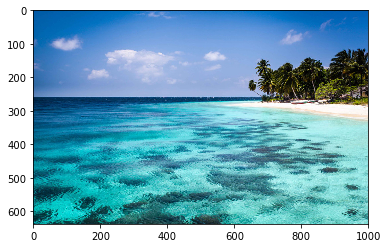

Match level: 0.6947756903546178


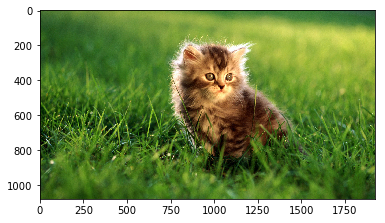

Result images from OpenCV method: "Hellinger" ========================================
Match level: 2.593829510439815e-07


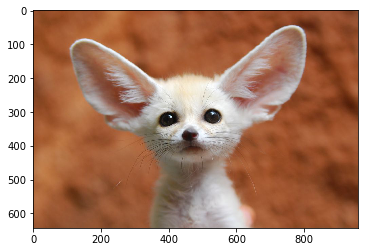

Match level: 0.7783603969279479


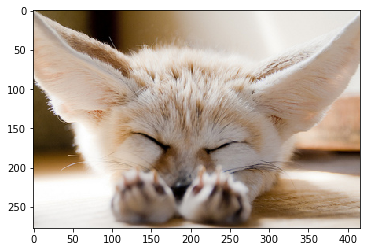

Match level: 0.8393106336225017


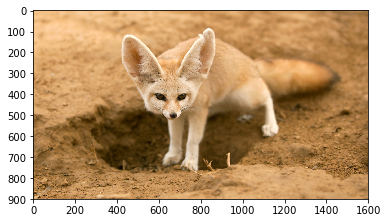

In [11]:
def run(): 
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]  
    queryFeatures = describe(query_path)  
    batch_extractor(images_path)
    database = Matcher(allfeatures_filename)
    
    print ('Query image ==========================================')
    show_img(query_path)
    
    
    print ('Now showing using SciPy distance functions ==================================================')
    for method in SCIPY_METHODS:
        matched = database.match(queryFeatures, method)
        matched = matched [:showNum]
        print ('Result images from SciPy distance function: "%s" ========================================' % method[1])
        for k,v in matched:
            # v is now the image name 
            # k is now the match level(difference/distance from the query image)
            print ('Match level: %s' % (k))
            show_img(os.path.join(images_path, v))
            
    print ('Now showing using OpenCV methods =======================================================')
    print ('These methods have shown to be less accurate than the SciPy distance functions for my particular database')
    for method in OPENCV_METHODS:
        matched = database.match(queryFeatures, method)
        matched = matched [:showNum]
        print ('Result images from OpenCV method: "%s" ========================================' % method[1])
        for k,v in matched:
            # v is now the image name 
            # k is now the match level(difference/distance from the query image)
            print ('Match level: %s' % (k))
            show_img(os.path.join(images_path, v))
    
    
# call the whole thing
run()

### Additional Resources
- [More about Histograms](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_2d_histogram/py_2d_histogram.html#twod-histogram)
- [More about Masking](https://stackoverflow.com/questions/10469235/opencv-apply-mask-to-a-color-image)
- [More about SciPy](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)
- [OpenCV Python, Image Search and Hashing](https://www.pyimagesearch.com/2017/11/27/image-hashing-opencv-python/)
